## Fruit Recognition

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed= 123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [5]:
len(dataset)

38

In [6]:
38*32

1216

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())
#     print(labels_batch.numpy())

[[[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 [[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 [[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 ...

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [251.95312 250.97656 251.95312]
  [251.95312 250.97656 251.95312]
  [251.95312 250.97656 251.95312]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [252.      251.      252.     ]
  [2

In [9]:
# visulaize

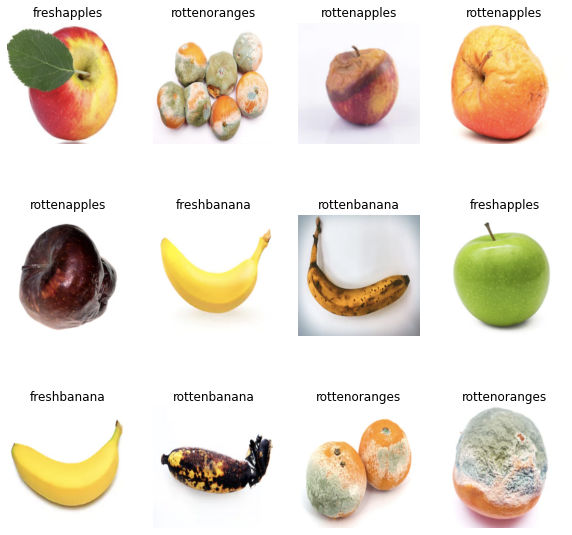

In [10]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [13]:
len(train_ds)

30

In [14]:
len(val_ds)

3

In [15]:
len(test_ds)

5

In [16]:
# shuffle

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
# building the build

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [21]:
# data augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
# apply data augmentation on training data

In [25]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# model

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
# compiling the model

In [33]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs = 35,
)

Epoch 1/35
 4/30 [===>..........................] - ETA: 58s - loss: 1.7793 - accuracy: 0.1875 